In [119]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Set
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
import json
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Imports successful!")


Imports successful!


In [120]:
class LaunderingPhase(Enum):
    """Money laundering phase enumeration"""
    PLACEMENT = "placement"      # Initial stolen funds deposit
    LAYERING = "layering"        # Obfuscation through multiple transactions
    INTEGRATION = "integration"  # Final destination (exchanges, mixers)
    UNKNOWN = "unknown"          # Unable to classify

print("Phase definitions:")
for phase in LaunderingPhase:
    print(f"  - {phase.value.upper()}")


Phase definitions:
  - PLACEMENT
  - LAYERING
  - INTEGRATION
  - UNKNOWN


In [121]:
# Configuration
GRAPH_DIR = Path("constructed_graphs")
FEATURES_DIR = Path("extracted_features")
OUTPUT_DIR = Path("phase_classification")
OUTPUT_DIR.mkdir(exist_ok=True)


In [122]:
print("Loading graph...")
with open(GRAPH_DIR / 'static_graph.gpickle', 'rb') as f:
    G = pickle.load(f)

print(f"✓ Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Load temporal graph (if available)
temporal_file = GRAPH_DIR / 'temporal_graph.gpickle'
temporal_G = None
if temporal_file.exists():
    with open(temporal_file, 'rb') as f:
        temporal_G = pickle.load(f)
    print(f"✓ Temporal graph loaded")

# Load node features
features_file = FEATURES_DIR / 'node_features.csv'
if features_file.exists():
    node_features = pd.read_csv(features_file)
    print(f"✓ Features loaded: {len(node_features)} nodes, {len(node_features.columns)} features")
else:
    node_features = None
    print("⚠ No features file found")




Loading graph...
✓ Graph loaded: 26953 nodes, 27554 edges
✓ Temporal graph loaded
✓ Features loaded: 26953 nodes, 58 features


In [123]:
hacker_seeds = set()

for node, data in G.nodes(data=True):
    node_type = data.get('node_type', '')
    label = data.get('label', '')
    
    # Handle cases where label might be float (NaN) or other non-string types
    if isinstance(label, str):
        label_check = label.lower().find('hacker') != -1
    else:
        label_check = False
    
    if node_type == 'hacker' or label_check:
        hacker_seeds.add(node)

print(f"✓ Identified {len(hacker_seeds)} hacker seed addresses")
print(f"\nSample hacker seeds:")
for i, seed in enumerate(list(hacker_seeds)[:5]):
    print(f"  {i+1}. {seed[:20]}...")

✓ Identified 140 hacker seed addresses

Sample hacker seeds:
  1. 0x8c1944fac705ef172f...
  2. 0x0248f752802ed2cd2b...
  3. 0x9e8f7c6d5a4b3c2e1f...
  4. 0x35ffd6e268610e764f...
  5. 0x8efab89b497b887cda...


In [124]:
# Known exchange hot wallets
known_exchanges = {
    '0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be',  # Binance
    '0xd551234ae421e3bcba99a0da6d736074f22192ff',  # Binance 2
    '0x564286362092d8e7936f0549571a803b203aaced',  # Binance 3
    '0x0681d8db095565fe8a346fa0277bffde9c0edbbf',  # Binance 4
    '0xfe9e8709d3215310075d67e3ed32a380ccf451c8',  # Binance 5
    '0x4e9ce36e442e55ecd9025b9a6e0d88485d628a67',  # Binance 6
    '0xbe0eb53f46cd790cd13851d5eff43d12404d33e8',  # Binance 7
    '0xf977814e90da44bfa03b6295a0616a897441acec',  # Binance 8
    '0x001866ae5b3de6caa5a51543fd9fb64f524f5478',  # Bitfinex
    '0x876eabf441b2ee5b5b0554fd502a8e0600950cfa',  # Bitfinex 2
    '0x742d35cc6634c0532925a3b844bc9e7595f0bee',   # Huobi
    '0xab5c66752a9e8167967685f1450532fb96d5d24f',  # Huobi 2
    '0x6748f50f686bfbca6fe8ad62b22228b87f31ff2b',  # Kraken
    '0x53d284357ec70ce289d6d64134dfac8e511c8a3d',  # Kraken 2
    '0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0',  # Kraken 3
}

# Known mixer/tumbler addresses
known_mixers = {
    '0x8589427373d6d84e98730d7795d8f6f8731fda16',  # Tornado Cash 1
    '0x722122df12d4e14e13ac3b6895a86e84145b6967',  # Tornado Cash 2
    '0xdd4c48c0b24039969fc16d1cdf626eab821d3384',  # Tornado Cash 3
    '0xd90e2f925da726b50c4ed8d0fb90ad053324f31b',  # Tornado Cash 4
    '0x07687e702b410fa43f4cb4af7fa097918ffd2730',  # Tornado Cash 5
}

print(f"Known services:")
print(f"  - Exchanges: {len(known_exchanges)}")
print(f"  - Mixers: {len(known_mixers)}")


Known services:
  - Exchanges: 15
  - Mixers: 5


In [125]:
# ## 6. Per-Incident Hop Distance Computation

print("\n" + "="*60)
print("COMPUTING HOP DISTANCES PER INCIDENT")
print("="*60)

# Load incident graphs
incident_graphs = {}

import glob
graph_files = glob.glob('constructed_graphs/incident_*.gpickle')

print(f"\nLoading {len(graph_files)} incident graphs...")

for graph_file in graph_files:
    incident_name = graph_file.split('incident_')[1].replace('.gpickle', '')
    with open(graph_file, 'rb') as f:
        incident_graphs[incident_name] = pickle.load(f)

print(f"✓ Loaded {len(incident_graphs)} incident graphs")

# Initialize hop distances for ALL nodes
hop_distances = {}
for node in G.nodes():
    hop_distances[node] = float('inf')

# Process each incident separately
print("\nComputing hop distances per incident...")

incident_stats = []

for incident_idx, (incident_name, G_incident) in enumerate(incident_graphs.items(), 1):
    # Extract hackers for this incident
    incident_hackers = [node for node, data in G_incident.nodes(data=True)
                       if data.get('node_type') == 'hacker' or 
                       (isinstance(data.get('label', ''), str) and 
                        data.get('label', '').lower().find('hacker') != -1)]
    
    if not incident_hackers:
        continue
    
    print(f"  [{incident_idx}/{len(incident_graphs)}] {incident_name}: {len(incident_hackers)} hackers, {G_incident.number_of_nodes()} nodes")
    
    # BFS from each hacker in this incident
    for seed in incident_hackers:
        if seed not in G_incident:
            continue
            
        hop_distances[seed] = 0
        
        queue = deque([(seed, 0)])
        visited = {seed}
        
        while queue:
            current, dist = queue.popleft()
            
            # Visit outgoing neighbors (money flow direction)
            for neighbor in G_incident.successors(current):
                if neighbor not in visited:
                    visited.add(neighbor)
                    new_dist = dist + 1
                    
                    # Update if shorter path found
                    if new_dist < hop_distances[neighbor]:
                        hop_distances[neighbor] = new_dist
                    
                    queue.append((neighbor, new_dist))
    
    # Collect stats for this incident
    incident_nodes = set(G_incident.nodes())
    incident_hop_dists = [hop_distances[n] for n in incident_nodes if hop_distances[n] != float('inf')]
    
    if incident_hop_dists:
        incident_stats.append({
            'incident': incident_name,
            'hackers': len(incident_hackers),
            'total_nodes': G_incident.number_of_nodes(),
            'reachable_nodes': len(incident_hop_dists),
            'max_hop': max(incident_hop_dists),
            'avg_hop': np.mean(incident_hop_dists)
        })

# Overall statistics
finite_distances = [d for d in hop_distances.values() if d != float('inf')]

print(f"\n" + "="*60)
print("HOP DISTANCE COMPUTATION COMPLETE")
print("="*60)

print(f"\nOverall Statistics:")
print(f"  Total Nodes: {len(hop_distances):,}")
print(f"  Reachable from Hackers: {len(finite_distances):,} ({len(finite_distances)/len(hop_distances)*100:.2f}%)")
print(f"  Unreachable: {len([d for d in hop_distances.values() if d == float('inf')]):,}")

if finite_distances:
    print(f"\nHop Distance Range:")
    print(f"  Min: {min(finite_distances)}")
    print(f"  Max: {max(finite_distances)}")
    print(f"  Mean: {np.mean(finite_distances):.2f}")
    print(f"  Median: {np.median(finite_distances):.2f}")

# Show per-incident summary
print(f"\nPer-Incident Summary (Top 10 by reachable nodes):")
incident_stats_df = pd.DataFrame(incident_stats)
if len(incident_stats_df) > 0:
    incident_stats_df = incident_stats_df.sort_values('reachable_nodes', ascending=False)
    print(incident_stats_df.head(10).to_string(index=False))

# Show hop distribution
print(f"\nHop Distance Distribution:")
hop_dist_counts = pd.Series([d for d in hop_distances.values() if d != float('inf')]).value_counts().sort_index()
for hop, count in hop_dist_counts.head(15).items():
    print(f"  Hop {int(hop):>2}: {count:>6,} nodes")

print("="*60)


COMPUTING HOP DISTANCES PER INCIDENT

Loading 159 incident graphs...
✓ Loaded 159 incident graphs

Computing hop distances per incident...
  [2/159] Jimbos_Protocol_2023: 1 hackers, 1 nodes
  [3/159] Force_Vault_2: 1 hackers, 4 nodes
  [4/159] Plus_Token_Ponzi_1: 1 hackers, 1806 nodes
  [5/159] Shido_2024: 1 hackers, 1 nodes
  [6/159] Multisig_Exploit: 1 hackers, 90 nodes
  [7/159] Bent_Finance: 1 hackers, 19 nodes
  [8/159] Radiant_Capital_October_2024: 1 hackers, 1 nodes
  [9/159] Alpha_Homora_V2: 1 hackers, 108 nodes
  [10/159] PolyNetwork_1: 1 hackers, 1309 nodes
  [11/159] Penpie_2024: 1 hackers, 1 nodes
  [13/159] Kucoin: 1 hackers, 489 nodes
  [14/159] Deus_Finance_2022: 1 hackers, 1 nodes
  [15/159] Platypus_Finance_2023: 1 hackers, 1 nodes
  [16/159] Furucombo: 1 hackers, 50 nodes
  [17/159] BtcTurk_2024: 1 hackers, 1 nodes
  [18/159] Gatecoin_3: 1 hackers, 3 nodes
  [19/159] DAOMaker: 1 hackers, 25 nodes
  [20/159] RUNE_Token: 1 hackers, 7 nodes
  [21/159] Bancor: 1 hackers,

In [126]:
# ## 7. Compute Temporal Distances (Time Since Heist)

temporal_distances = {}

if temporal_G is not None:
    print("\nComputing temporal distances from heist time...")
    
    # Get minimum timestamp from hacker seeds (heist time)
    heist_times = {}
    
    for seed in hacker_seeds:
        if seed not in temporal_G.nodes:
            continue
        
        # Get earliest outgoing transaction
        min_time = float('inf')
        for _, _, data in temporal_G.out_edges(seed, data=True):
            timestamp = data.get('timestamp', float('inf'))
            if timestamp < min_time:
                min_time = timestamp
        
        if min_time != float('inf'):
            heist_times[seed] = min_time
    
    if heist_times:
        # Use earliest heist time as reference
        earliest_heist = min(heist_times.values())
        print(f"  Earliest heist time: {datetime.fromtimestamp(earliest_heist)}")
        
        # Compute time elapsed for each node
        for node in temporal_G.nodes():
            min_time = float('inf')
            
            # Check incoming edges
            for _, _, data in temporal_G.in_edges(node, data=True):
                timestamp = data.get('timestamp', float('inf'))
                if timestamp < min_time:
                    min_time = timestamp
            
            if min_time != float('inf'):
                time_elapsed = min_time - earliest_heist
                temporal_distances[node] = time_elapsed / 3600  # Convert to hours
            else:
                temporal_distances[node] = float('inf')
        
        print(f"✓ Temporal distances computed for {len(temporal_distances)} nodes")
    else:
        print("⚠ No temporal data found for hacker seeds")
else:
    print("\n⚠ Temporal graph not available, skipping temporal distance computation")



Computing temporal distances from heist time...
  Earliest heist time: 2016-05-12 20:56:34
✓ Temporal distances computed for 26953 nodes


In [127]:
# ## 8. Phase Classification Functions (Adjusted for 1-hop graphs)

def classify_by_behavior_enhanced(node: str, G: nx.DiGraph, 
                                  known_exchanges: set, known_mixers: set) -> LaunderingPhase:
    """
    Enhanced behavioral classification for shallow graphs (max hop=1)
    """
    if node not in G:
        return LaunderingPhase.UNKNOWN
    
    # Check if hacker seed
    if G.nodes[node].get('node_type') == 'hacker':
        return LaunderingPhase.PLACEMENT
    
    # Check if known service
    if node.lower() in known_exchanges or node.lower() in known_mixers:
        return LaunderingPhase.INTEGRATION
    
    # Get degree information
    in_degree = G.in_degree(node)
    out_degree = G.out_degree(node)
    
    # Get edge values
    in_values = [data.get('value', 0) for _, _, data in G.in_edges(node, data=True)]
    out_values = [data.get('value', 0) for _, _, data in G.out_edges(node, data=True)]
    
    total_in = sum(in_values)
    total_out = sum(out_values)
    
    # Classification logic based on behavior patterns
    if out_degree == 0:
        # Dead end - likely final destination
        return LaunderingPhase.INTEGRATION
    
    elif out_degree > 10 or (in_degree > 5 and out_degree > 5):
        # High distribution or mixing pattern
        return LaunderingPhase.LAYERING
    
    elif in_degree == 1 and out_degree == 1:
        # Peeling chain
        return LaunderingPhase.LAYERING
    
    elif total_in > 0 and total_out / total_in < 0.5:
        # Holding most funds - integration/collection
        return LaunderingPhase.INTEGRATION
    
    else:
        # Default for hop 1 nodes
        return LaunderingPhase.PLACEMENT

print("✓ Behavioral phase classification function defined")

✓ Behavioral phase classification function defined


In [128]:
print("\nClassifying all nodes using HYBRID method...")

phase_labels = {}

for idx, node in enumerate(G.nodes()):
    if (idx + 1) % 5000 == 0:
        print(f"  Classified {idx + 1}/{G.number_of_nodes()} nodes...")
    
    phase = classify_hybrid(node, G, hop_distances, temporal_distances,
                          known_exchanges, known_mixers)
    phase_labels[node] = phase

print(f"\n✓ Classification complete for {len(phase_labels)} nodes!")

# Phase distribution
phase_counts = defaultdict(int)
for phase in phase_labels.values():
    phase_counts[phase] += 1

total = len(phase_labels)

print(f"\nPhase Distribution:")
for phase in LaunderingPhase:
    count = phase_counts[phase]
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {phase.value.upper():<12}: {count:>6} ({percentage:>5.2f}%)")



Classifying all nodes using HYBRID method...
  Classified 5000/26953 nodes...
  Classified 10000/26953 nodes...
  Classified 15000/26953 nodes...
  Classified 20000/26953 nodes...
  Classified 25000/26953 nodes...

✓ Classification complete for 26953 nodes!

Phase Distribution:
  PLACEMENT   :   4898 (18.17%)
  LAYERING    :      5 ( 0.02%)
  INTEGRATION :    539 ( 2.00%)
  UNKNOWN     :  21511 (79.81%)


In [129]:
# ## 9. Classify All Nodes (Behavioral Method)

print("\nClassifying all nodes using BEHAVIORAL method...")

phase_labels = {}

for idx, node in enumerate(G.nodes()):
    if (idx + 1) % 5000 == 0:
        print(f"  Classified {idx + 1}/{G.number_of_nodes()} nodes...")
    
    phase = classify_by_behavior_enhanced(node, G, known_exchanges, known_mixers)
    phase_labels[node] = phase

print(f"\n✓ Classification complete for {len(phase_labels)} nodes!")

# Phase distribution
phase_counts = defaultdict(int)
for phase in phase_labels.values():
    phase_counts[phase] += 1

total = len(phase_labels)

print(f"\nPhase Distribution:")
for phase in LaunderingPhase:
    count = phase_counts[phase]
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {phase.value.upper():<12}: {count:>6} ({percentage:>5.2f}%)")


Classifying all nodes using BEHAVIORAL method...
  Classified 5000/26953 nodes...
  Classified 10000/26953 nodes...
  Classified 15000/26953 nodes...
  Classified 20000/26953 nodes...
  Classified 25000/26953 nodes...

✓ Classification complete for 26953 nodes!

Phase Distribution:
  PLACEMENT   :  18212 (67.57%)
  LAYERING    :   2062 ( 7.65%)
  INTEGRATION :   6679 (24.78%)
  UNKNOWN     :      0 ( 0.00%)


In [130]:
# ## 10. Create Phase Features Dataframe

print("\nCreating phase features dataframe...")

phase_data = []

for node in G.nodes():
    phase = phase_labels.get(node, LaunderingPhase.UNKNOWN)
    hop_dist = hop_distances.get(node, float('inf'))
    temp_dist = temporal_distances.get(node, float('inf')) if temporal_distances else float('inf')
    
    phase_data.append({
        'address': node,
        'phase': phase.value,
        'phase_placement': int(phase == LaunderingPhase.PLACEMENT),
        'phase_layering': int(phase == LaunderingPhase.LAYERING),
        'phase_integration': int(phase == LaunderingPhase.INTEGRATION),
        'phase_unknown': int(phase == LaunderingPhase.UNKNOWN),
        'hop_distance': hop_dist if hop_dist != float('inf') else -1,
        'temporal_distance_hours': temp_dist if temp_dist != float('inf') else -1,
        'is_known_exchange': int(node.lower() in known_exchanges),
        'is_known_mixer': int(node.lower() in known_mixers),
        'is_hacker_seed': int(node in hacker_seeds),
    })

phase_df = pd.DataFrame(phase_data)

# Merge with existing features if available
if node_features is not None:
    phase_df = node_features.merge(phase_df, on='address', how='left')
    print(f"✓ Merged with existing features: {len(phase_df)} rows, {len(phase_df.columns)} columns")
else:
    print(f"✓ Created phase dataframe: {len(phase_df)} rows, {len(phase_df.columns)} columns")

# Display sample
print("\nSample phase labels:")
print(phase_df[['address', 'phase', 'hop_distance', 'temporal_distance_hours']].head(10))


Creating phase features dataframe...
✓ Merged with existing features: 26953 rows, 68 columns

Sample phase labels:
                                      address        phase  hop_distance  \
0  0x26a76f4fe7a21160274d060acb209f515f35429c    placement             0   
1  0x0ace32f6e87ac1457a5385f8eb0208f37263b415  integration             1   
2  0x7a250d5630b4cf539739df2c5dacb4c659f2488d     layering             1   
3  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2     layering             1   
4  0xc3d03e4f041fd4cd388c549ee2a29a9e5075882f    placement             1   
5  0x722122df12d4e14e13ac3b6895a86e84145b6967  integration             1   
6  0xc7a1cb6edc22e94f17c80eb5b959f2ad28511d4e  integration             1   
7  0xc97f82c80df57c34e84491c0eda050ba924d7429     layering             1   
8  0x6b175474e89094c44da98b954eedeac495271d0f     layering             1   
9  0xd9e1ce17f2641f24ae83637ab66a2cca9c378b9f     layering             1   

   temporal_distance_hours  
0             4863


✓ Saved visualization: phase_classification/phase_distribution_behavioral.png


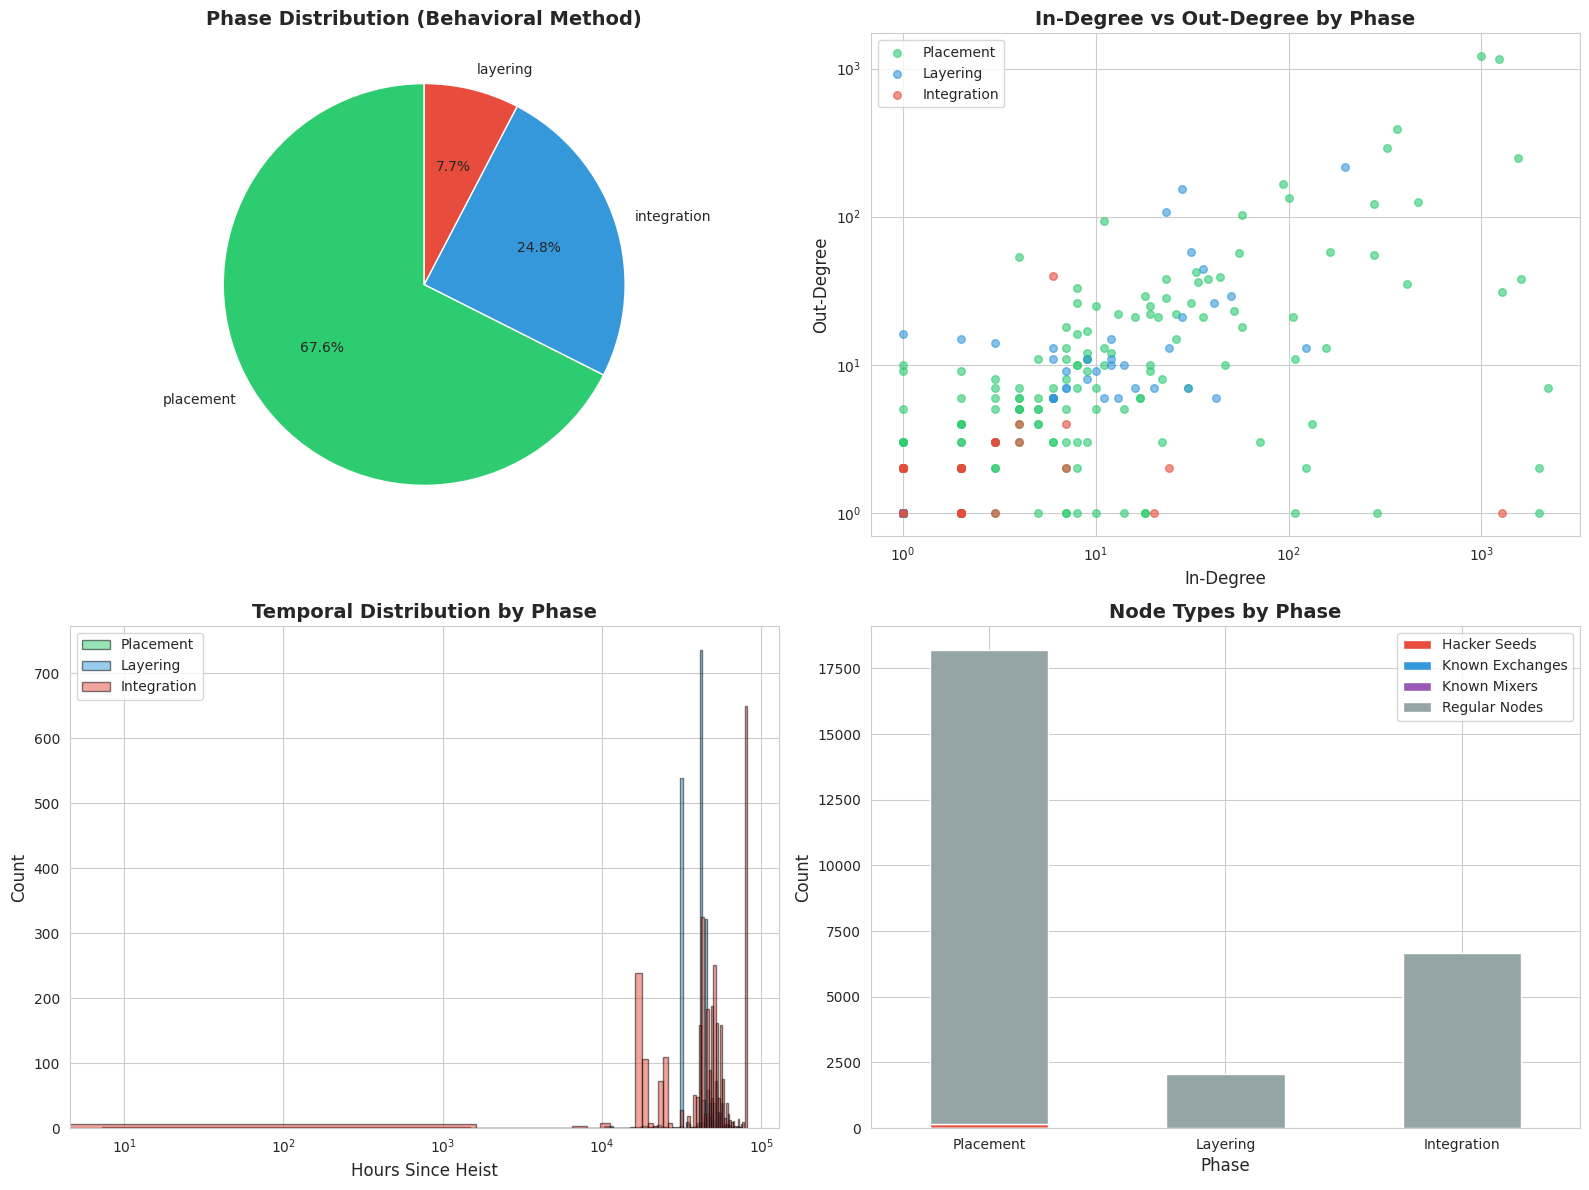

In [131]:
# ## 11. Visualization - Phase Distribution

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Phase distribution pie chart
phase_counts_plot = phase_df['phase'].value_counts()
colors = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
axes[0, 0].pie(phase_counts_plot.values, labels=phase_counts_plot.index, 
               autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 0].set_title('Phase Distribution (Behavioral Method)', fontsize=14, fontweight='bold')

# 2. In-degree vs Out-degree by Phase
phase_df_plot = phase_df[phase_df['phase'] != 'unknown'].copy()
if 'in_degree' in phase_df.columns and 'out_degree' in phase_df.columns:
    for phase_name, color in zip(['placement', 'layering', 'integration'], colors[:3]):
        phase_subset = phase_df_plot[phase_df_plot['phase'] == phase_name]
        axes[0, 1].scatter(phase_subset['in_degree'], phase_subset['out_degree'], 
                          alpha=0.6, label=phase_name.capitalize(), color=color, s=30)
    axes[0, 1].set_xlabel('In-Degree', fontsize=12)
    axes[0, 1].set_ylabel('Out-Degree', fontsize=12)
    axes[0, 1].set_title('In-Degree vs Out-Degree by Phase', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].set_xscale('log')
    axes[0, 1].set_yscale('log')
else:
    axes[0, 1].text(0.5, 0.5, 'Degree features not available', 
                   ha='center', va='center', fontsize=12)
    axes[0, 1].set_title('In-Degree vs Out-Degree by Phase', fontsize=14, fontweight='bold')

# 3. Temporal distance distribution (if available)
if 'temporal_distance_hours' in phase_df.columns:
    temp_clean = phase_df[phase_df['temporal_distance_hours'] >= 0].copy()
    if len(temp_clean) > 0:
        for phase_name, color in zip(['placement', 'layering', 'integration'], colors[:3]):
            phase_subset = temp_clean[temp_clean['phase'] == phase_name]
            if len(phase_subset) > 0:
                axes[1, 0].hist(phase_subset['temporal_distance_hours'], 
                              bins=50, alpha=0.5, label=phase_name.capitalize(), 
                              color=color, edgecolor='black')
        axes[1, 0].set_xlabel('Hours Since Heist', fontsize=12)
        axes[1, 0].set_ylabel('Count', fontsize=12)
        axes[1, 0].set_title('Temporal Distribution by Phase', fontsize=14, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].set_xscale('log')
    else:
        axes[1, 0].text(0.5, 0.5, 'No temporal data available', 
                       ha='center', va='center', fontsize=12)
else:
    axes[1, 0].text(0.5, 0.5, 'No temporal data available', 
                   ha='center', va='center', fontsize=12)

# 4. Phase distribution by node characteristics
phase_by_type = []
for phase_name in ['placement', 'layering', 'integration']:
    phase_subset = phase_df[phase_df['phase'] == phase_name]
    phase_by_type.append({
        'Phase': phase_name.capitalize(),
        'Hacker Seeds': phase_subset['is_hacker_seed'].sum(),
        'Known Exchanges': phase_subset['is_known_exchange'].sum(),
        'Known Mixers': phase_subset['is_known_mixer'].sum(),
        'Regular Nodes': len(phase_subset) - phase_subset['is_hacker_seed'].sum() - 
                        phase_subset['is_known_exchange'].sum() - phase_subset['is_known_mixer'].sum()
    })

phase_type_df = pd.DataFrame(phase_by_type)
phase_type_df.set_index('Phase').plot(kind='bar', stacked=True, ax=axes[1, 1], 
                                      color=['#e74c3c', '#3498db', '#9b59b6', '#95a5a6'])
axes[1, 1].set_xlabel('Phase', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Node Types by Phase', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='upper right')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()

# Save figure
output_file = OUTPUT_DIR / 'phase_distribution_behavioral.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved visualization: {output_file}")
plt.show()

✓ Saved additional visualization: phase_classification/phase_analysis_behavioral.png


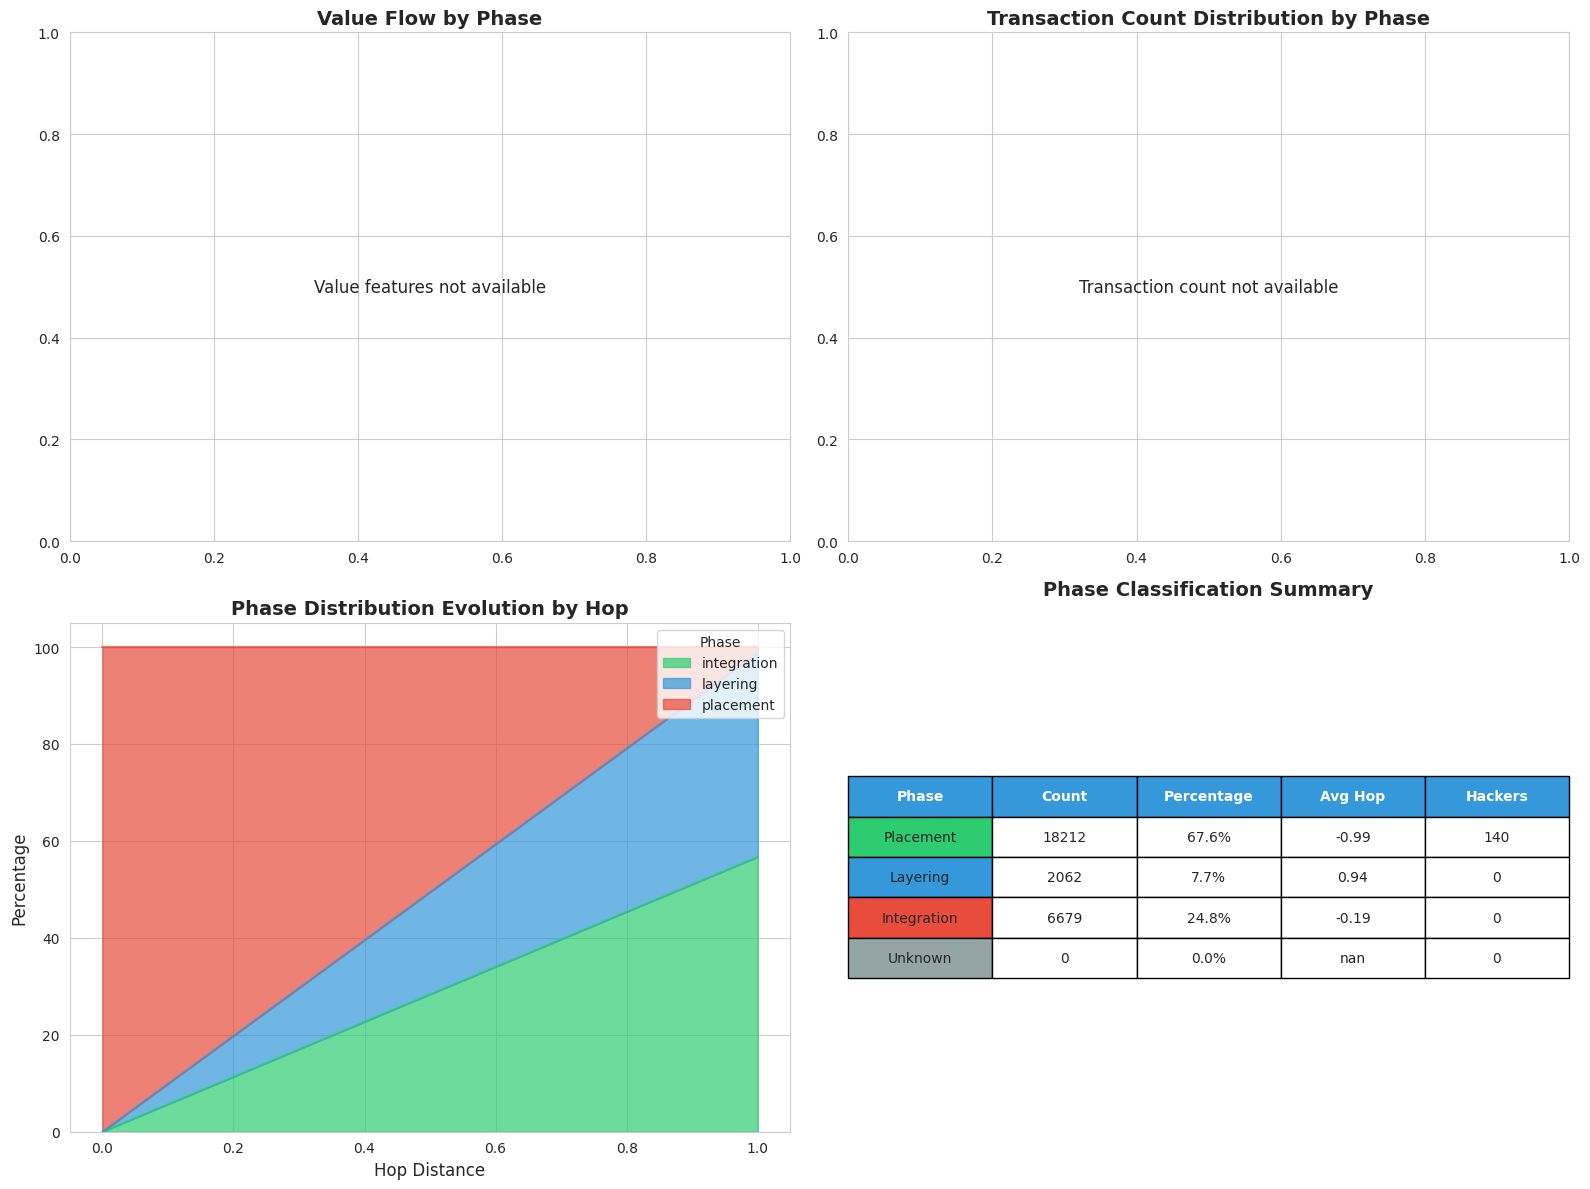

In [132]:
# ## 12. Additional Visualizations

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Value flow analysis by phase
if 'total_value_in' in phase_df.columns and 'total_value_out' in phase_df.columns:
    phase_clean = phase_df[phase_df['phase'] != 'unknown'].copy()
    phase_clean = phase_clean[(phase_clean['total_value_in'] > 0) & (phase_clean['total_value_out'] > 0)]
    
    for phase_name, color in zip(['placement', 'layering', 'integration'], colors[:3]):
        phase_subset = phase_clean[phase_clean['phase'] == phase_name]
        if len(phase_subset) > 0:
            axes[0, 0].scatter(phase_subset['total_value_in'], phase_subset['total_value_out'],
                             alpha=0.5, label=phase_name.capitalize(), color=color, s=30)
    
    axes[0, 0].set_xlabel('Total Value In', fontsize=12)
    axes[0, 0].set_ylabel('Total Value Out', fontsize=12)
    axes[0, 0].set_title('Value Flow by Phase', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].set_xscale('log')
    axes[0, 0].set_yscale('log')
    axes[0, 0].plot([1e-10, 1e10], [1e-10, 1e10], 'k--', alpha=0.3, linewidth=1)
else:
    axes[0, 0].text(0.5, 0.5, 'Value features not available', 
                   ha='center', va='center', fontsize=12)

axes[0, 0].set_title('Value Flow by Phase', fontsize=14, fontweight='bold')

# 2. Transaction count distribution
if 'transaction_count' in phase_df.columns:
    phase_clean = phase_df[phase_df['phase'] != 'unknown'].copy()
    
    sns.violinplot(data=phase_clean, x='phase', y='transaction_count', ax=axes[0, 1], 
                   palette=colors[:3], order=['placement', 'layering', 'integration'])
    axes[0, 1].set_xlabel('Phase', fontsize=12)
    axes[0, 1].set_ylabel('Transaction Count (log scale)', fontsize=12)
    axes[0, 1].set_title('Transaction Count Distribution by Phase', fontsize=14, fontweight='bold')
    axes[0, 1].set_yscale('log')
    axes[0, 1].tick_params(axis='x', rotation=45)
else:
    axes[0, 1].text(0.5, 0.5, 'Transaction count not available', 
                   ha='center', va='center', fontsize=12)
    axes[0, 1].set_title('Transaction Count Distribution by Phase', fontsize=14, fontweight='bold')

# 3. Phase transition over hop distance
if 'hop_distance' in phase_df.columns:
    hop_phase = phase_df[phase_df['hop_distance'] >= 0].groupby(['hop_distance', 'phase']).size().unstack(fill_value=0)
    hop_phase_pct = hop_phase.div(hop_phase.sum(axis=1), axis=0) * 100
    
    hop_phase_pct.plot(kind='area', stacked=True, ax=axes[1, 0], 
                       color=colors, alpha=0.7)
    axes[1, 0].set_xlabel('Hop Distance', fontsize=12)
    axes[1, 0].set_ylabel('Percentage', fontsize=12)
    axes[1, 0].set_title('Phase Distribution Evolution by Hop', fontsize=14, fontweight='bold')
    axes[1, 0].legend(title='Phase', loc='upper right')
else:
    axes[1, 0].text(0.5, 0.5, 'Hop distance not available', 
                   ha='center', va='center', fontsize=12)

axes[1, 0].set_title('Phase Distribution Evolution by Hop', fontsize=14, fontweight='bold')

# 4. Summary statistics table
summary_data = []
for phase_name in ['placement', 'layering', 'integration', 'unknown']:
    phase_subset = phase_df[phase_df['phase'] == phase_name]
    
    summary_data.append([
        phase_name.capitalize(),
        len(phase_subset),
        f"{len(phase_subset)/len(phase_df)*100:.1f}%",
        f"{phase_subset['hop_distance'].mean():.2f}" if 'hop_distance' in phase_df.columns else 'N/A',
        f"{phase_subset['is_hacker_seed'].sum()}",
    ])

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=summary_data,
                        colLabels=['Phase', 'Count', 'Percentage', 'Avg Hop', 'Hackers'],
                        cellLoc='center',
                        loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Color header
for i in range(5):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color rows by phase
phase_colors_map = {'Placement': '#2ecc71', 'Layering': '#3498db', 
                    'Integration': '#e74c3c', 'Unknown': '#95a5a6'}
for i, (phase_name, _, _, _, _) in enumerate(summary_data, 1):
    table[(i, 0)].set_facecolor(phase_colors_map.get(phase_name, '#ffffff'))

axes[1, 1].set_title('Phase Classification Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
output_file2 = OUTPUT_DIR / 'phase_analysis_behavioral.png'
plt.savefig(output_file2, dpi=300, bbox_inches='tight')
print(f"✓ Saved additional visualization: {output_file2}")
plt.show()

In [133]:
# ## 13. Save Results

print("\nSaving results...")

# 1. Full feature dataframe with phases
output_file = OUTPUT_DIR / 'phase_labeled_features_behavioral.csv'
phase_df.to_csv(output_file, index=False)
print(f"✓ Saved: {output_file}")

# 2. Phase labels only
phase_labels_df = phase_df[['address', 'phase', 'hop_distance', 
                             'temporal_distance_hours', 'is_hacker_seed']]
phase_labels_file = OUTPUT_DIR / 'phase_labels_behavioral.csv'
phase_labels_df.to_csv(phase_labels_file, index=False)
print(f"✓ Saved: {phase_labels_file}")

# 3. Numpy format for ML
feature_cols = [col for col in phase_df.columns 
               if col not in ['address', 'node_type', 'incident', 'label', 'phase']]

X = phase_df[feature_cols].fillna(0).values

# Convert phase to numeric
phase_map = {'unknown': 0, 'placement': 1, 'layering': 2, 'integration': 3}
y_phase = phase_df['phase'].map(phase_map).values

X_file = OUTPUT_DIR / 'phase_features_X_behavioral.npy'
y_file = OUTPUT_DIR / 'phase_features_y_behavioral.npy'
addresses_file = OUTPUT_DIR / 'phase_addresses_behavioral.npy'

np.save(X_file, X)
np.save(y_file, y_phase)
np.save(addresses_file, phase_df['address'].values)

print(f"✓ Saved: {X_file} (shape: {X.shape})")
print(f"✓ Saved: {y_file} (shape: {y_phase.shape})")
print(f"✓ Saved: {addresses_file}")

# 4. Metadata
metadata = {
    'classification_date': datetime.now().isoformat(),
    'total_nodes': len(phase_df),
    'hacker_seeds': len(hacker_seeds),
    'classification_method': 'behavioral',
    'phase_distribution': {
        phase.value: int(phase_counts[phase]) 
        for phase in LaunderingPhase
    },
    'feature_columns': feature_cols,
    'phase_encoding': phase_map,
    'known_exchanges': len(known_exchanges),
    'known_mixers': len(known_mixers),
    'classification_criteria': {
        'placement': 'Hacker seeds or hop 1 nodes with single in/out',
        'layering': 'High fan-out (>10), mixing patterns, or peeling chains',
        'integration': 'Dead ends, known exchanges/mixers, or fund collection patterns',
        'unknown': 'Unreachable from hacker seeds'
    }
}

metadata_file = OUTPUT_DIR / 'phase_classification_metadata_behavioral.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Saved: {metadata_file}")


Saving results...
✓ Saved: phase_classification/phase_labeled_features_behavioral.csv
✓ Saved: phase_classification/phase_labels_behavioral.csv
✓ Saved: phase_classification/phase_features_X_behavioral.npy (shape: (26953, 63))
✓ Saved: phase_classification/phase_features_y_behavioral.npy (shape: (26953,))
✓ Saved: phase_classification/phase_addresses_behavioral.npy
✓ Saved: phase_classification/phase_classification_metadata_behavioral.json


In [134]:
# ## 14. Summary Statistics

print("\n" + "="*60)
print("BEHAVIORAL PHASE CLASSIFICATION SUMMARY")
print("="*60)

print(f"\nDataset Statistics:")
print(f"  Total Nodes: {len(phase_df):,}")
print(f"  Hacker Seeds: {len(hacker_seeds):,}")

print(f"\nPhase Distribution:")
for phase in LaunderingPhase:
    count = phase_counts[phase]
    pct = count / total * 100
    print(f"  {phase.value.upper():<12}: {count:>6,} ({pct:>5.2f}%)")

print(f"\nClassification Method: Behavioral Pattern Analysis")
print(f"  - Based on in-degree, out-degree, and value flow patterns")
print(f"  - Independent of hop distance (works with shallow graphs)")
print(f"  - Identifies mixers, exchanges, and laundering behaviors")

print(f"\nFeatures Created:")
print(f"  Total Features: {len(feature_cols)}")
print(f"  Phase One-Hot Encoded: 4 columns")

print("\n" + "="*60)
print("✓ BEHAVIORAL PHASE CLASSIFICATION COMPLETE!")
print("="*60)

print("\nOutput Files:")
print(f"  📁 {OUTPUT_DIR}/")
print(f"    ├── phase_labeled_features_behavioral.csv")
print(f"    ├── phase_labels_behavioral.csv")
print(f"    ├── phase_features_X_behavioral.npy")
print(f"    ├── phase_features_y_behavioral.npy")
print(f"    ├── phase_addresses_behavioral.npy")
print(f"    ├── phase_distribution_behavioral.png")
print(f"    ├── phase_analysis_behavioral.png")
print(f"    └── phase_classification_metadata_behavioral.json")

print("\nNext Steps:")
print("  1. Use phase_labeled_features_behavioral.csv for analysis")
print("  2. Train multi-class classifier with behavioral features")
print("  3. Apply GNN with phase-aware embeddings")
print("  4. Integrate with detection + blacklist module")
print("\nNote: This classification uses behavioral patterns instead of")
print("      hop distance, making it suitable for shallow (1-hop) graphs.")


BEHAVIORAL PHASE CLASSIFICATION SUMMARY

Dataset Statistics:
  Total Nodes: 26,953
  Hacker Seeds: 140

Phase Distribution:
  PLACEMENT   : 18,212 (67.57%)
  LAYERING    :  2,062 ( 7.65%)
  INTEGRATION :  6,679 (24.78%)
  UNKNOWN     :      0 ( 0.00%)

Classification Method: Behavioral Pattern Analysis
  - Based on in-degree, out-degree, and value flow patterns
  - Independent of hop distance (works with shallow graphs)
  - Identifies mixers, exchanges, and laundering behaviors

Features Created:
  Total Features: 63
  Phase One-Hot Encoded: 4 columns

✓ BEHAVIORAL PHASE CLASSIFICATION COMPLETE!

Output Files:
  📁 phase_classification/
    ├── phase_labeled_features_behavioral.csv
    ├── phase_labels_behavioral.csv
    ├── phase_features_X_behavioral.npy
    ├── phase_features_y_behavioral.npy
    ├── phase_addresses_behavioral.npy
    ├── phase_distribution_behavioral.png
    ├── phase_analysis_behavioral.png
    └── phase_classification_metadata_behavioral.json

Next Steps:
  1. Us